# Analyzed Videos EDA

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import vizualisation as viz

In [7]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'
path_to_root = 'c:\\Users\\benthompson\\source\\prepos\\brsl'

In [8]:
metadata = pd.read_csv(path_to_root + '/data/raw/combined/target_dataset_video_metadata.csv')

In [9]:
i = -1
metadata_row = metadata.iloc[i].copy()
metadata_row

filename        vagina_vl_6.mp4
label                       NaN
data_source                 NaN
frame_count                 389
fps                        60.0
duration_sec           6.483333
width                      1920
height                     1080
Name: 155, dtype: object

## Full Dataset Analysis Info

In [10]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [11]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "interim", 
        "Analysis", 
        "28032025", 
        "individual_json", 
        fn.split(".")[0] + "_analysis_info.json"
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [12]:
analysis_info = pd.concat(analysis_info_list, axis = 0)

In [13]:
analysis_info['metadata_duration_sec'] = metadata['duration_sec'].values

### Visualise Ref Landmakrs

In [14]:
analysis_info_dict

{'metadata': {'filename': 'vagina_vl_6.mp4',
  'fps': 60,
  'width': 1920,
  'height': 1080,
  'duration_sec': 6.0,
  'frame_count': 389,
  'data_source': 'vl',
  'label': 'vagina',
  'motion_detection_version': 'versionA',
  'pose_detection_version': 'versionA',
  'timestamp': '28032025'},
 'params': {'motion_avg_weights': {'basic': 0.3, 'bg_sub': 0.7},
  'moving_avg_window_duration': 0.2,
  'motion_threshold_method': 'simple',
  'motion_start_threshold': 0.3,
  'motion_end_threshold': 0.2,
  'pose_static_image_mode': False,
  'pose_model_complexity': 1,
  'pose_smooth_landmarks': True,
  'pose_min_detection_confidence': 0.5,
  'pose_min_tracking_confidence': 0.5,
  'reuse_results': True},
 'motion_analysis': {'start_frame': 43,
  'end_frame': 383,
  'start_time': 0.7166666666666667,
  'end_time': 6.383333333333334,
  'duration_frames': 340,
  'duration_sec': 5.666666666666667},
 'pose_analysis': {'frames_with_landmarks': 389,
  'horizontal_offsets': {'shoulders': {'mean': 0.521565651

In [15]:
analysis_info_dict['pose_analysis']['vertical_offsets']

{'shoulders': {'mean': 0.4905801490523821,
  'median': 0.49526895582675934,
  'max': 0.5092040002346039,
  'min': 0.4706456810235977},
 'face': {'mean': 0.25904286448544683,
  'median': 0.26554471254348755,
  'max': 0.2951558232307434,
  'min': 0.21445389091968536}}

In [16]:
analysis_info_dict['pose_analysis']['landmark_measurements']

{'shoulder_width': {'mean': 0.2753713688882756,
  'median': 0.27267894277897653,
  'max': 0.286880532250224},
 'hip_width': {'mean': 0.20354587900186413,
  'median': 0.20292951752996966,
  'max': 0.2176895736547159},
 'shoulder_to_hip': {'mean': 0.6368293995912917,
  'median': 0.6442427599405243,
  'max': 0.6947214825081325},
 'left_arm_length': {'mean': 0.2521641842757136,
  'median': 0.2509274511028774,
  'max': 0.2878048371110993},
 'right_arm_length': {'mean': 0.26682496010275597,
  'median': 0.24374788527699284,
  'max': 0.37390825186719134},
 'face_width': {'mean': 0.12202723846198506,
  'median': 0.12185068657500671,
  'max': 0.16726724724202766},
 'face_height': {'mean': 0.2315856883446511,
  'median': 0.23013742890308236,
  'max': 0.3040554742154432},
 'top_head_to_shoulders': {'mean': 0.3337155120646673,
  'median': 0.33742500841617584,
  'max': 0.38858743011951447},
 'nose_to_shoulders': {'mean': 0.2315019631354678,
  'median': 0.22867536544799805,
  'max': 0.285626009106636

In [17]:
def plot_key_landmarks(
    landmark_points: dict, 
    frame = None, 
    line_color = (0,255,0),
    line_width = 2,
    triangle = False,
    ):
    """make face oval from face width, height, very offset and horizontal offset
    Make torso from shoulders width and vertical offset and horizontal offset
    To show the reference ones, we have a few different prams that overlap
    face vert and shoulders vert depend on face top and chin to shoulders
    Which depends on shoulders to bottom."
    """
    if frame is None:
        frame = np.zeros([1000,1000,3])
    frame_height, frame_width = frame.shape[0], frame.shape[1]

    # get face points    
    face_center_x = landmark_points['face_horizontal_offset']*frame_width
    face_center_y = landmark_points['face_vertical_offset']*frame_height
    face_width = landmark_points['face_width']*frame_width
    face_height = landmark_points['face_height']*frame_height

    # draw an oval matching the points
    # cv2.ellipse(image, center, axes, angle, startAngle, endAngle, color, thickness)
    cv2.ellipse(
        frame, 
        (int(face_center_x), int(face_center_y)), 
        (int(face_width/2), int(face_height/2)), 
        0, 
        0, 
        360, 
        line_color, 
        line_width
    )
    
    # get shoulder points
    shoulders_center_x = landmark_points['shoulders_horizontal_offset']*frame_width
    shoulders_center_y = landmark_points['shoulders_vertical_offset']*frame_height
    shoulders_width = landmark_points['shoulders_width']*frame_width

    if triangle:
        shoulder_left = (int(shoulders_center_x - shoulders_width/2), int(shoulders_center_y))
        shoulder_right = (int(shoulders_center_x + shoulders_width/2), int(shoulders_center_y))
        torso_bottom = (int(shoulders_center_x), frame.shape[0])

        cv2.line(
            frame,
            shoulder_left,
            shoulder_right,
            line_color, 
            line_width
        )
        cv2.line(
            frame,
            shoulder_left,
            torso_bottom,
            line_color, 
            line_width
        )
        cv2.line(
            frame,
            shoulder_right,
            torso_bottom,
            line_color, 
            line_width
        )
        
    if not triangle:
        # draw a rectangle from the shoulder line to the bottom
        shoulder_left = (int(shoulders_center_x - shoulders_width/2), int(shoulders_center_y))
        shoulder_right = (int(shoulders_center_x + shoulders_width/2), frame.shape[0]) 
        cv2.rectangle(
            frame,
            shoulder_left,
            shoulder_right,
            line_color, 
            line_width
        )
    return frame

In [18]:
key_points2 = {
    'face_horizontal_offset': analysis_info_dict['pose_analysis']['horizontal_offsets']['face']['median'],
    'face_vertical_offset': analysis_info_dict['pose_analysis']['vertical_offsets']['face']['median'],
    'face_width': analysis_info_dict['pose_analysis']['landmark_measurements']['face_width']['median'],
    'face_height': analysis_info_dict['pose_analysis']['landmark_measurements']['face_height']['median'],
    'shoulders_horizontal_offset': analysis_info_dict['pose_analysis']['horizontal_offsets']['shoulders']['median'],
    'shoulders_vertical_offset': analysis_info_dict['pose_analysis']['vertical_offsets']['shoulders']['median'],
    'shoulders_width': analysis_info_dict['pose_analysis']['landmark_measurements']['shoulder_width']['median'],
}

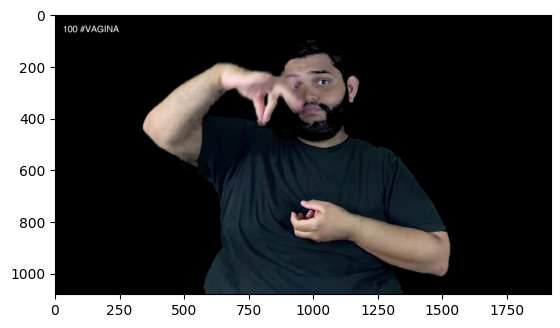

In [19]:
frame = viz.get_frame(
    100,
    os.path.join(path_to_root, 'data/raw/combined/videos', metadata_row.filename)
    )
plt.imshow(frame)

In [ ]:
vix.

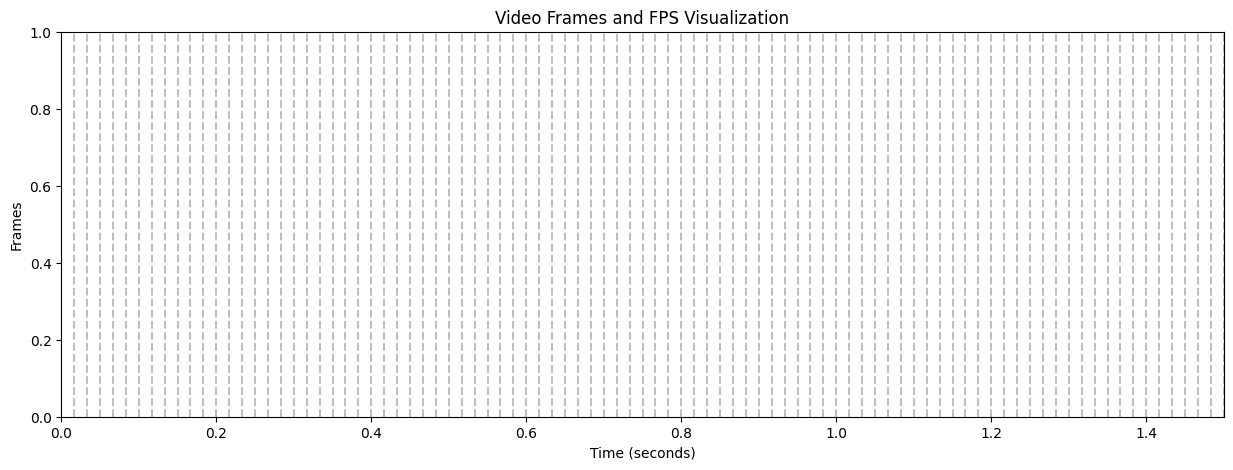

In [51]:
fps_plot = viz.plot_video_frames_with_fps(
    os.path.join(path_to_root, 'data/raw/combined/videos', metadata_row.filename),
    1.5,
    50
)

In [50]:
plt.imshow(fps_plot)

NameError: name 'fps_plot' is not defined

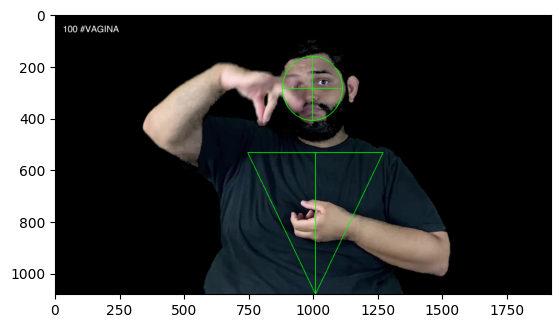

In [20]:
drawn = viz.plot_key_landmarks(key_points2, frame)
plt.imshow(drawn)

In [21]:
mph = viz.MediaPipeHolistic()

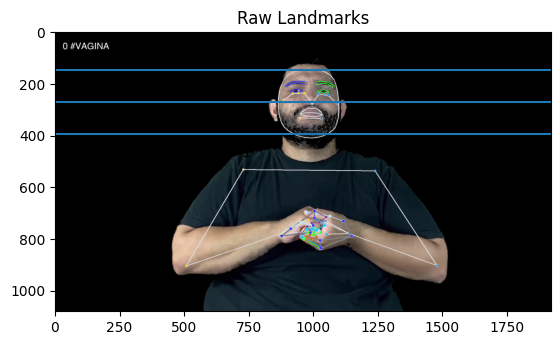

In [ ]:
i = 0
landmarks = np.load(os.path.join(
    path_to_root,
    "data",
    "interim",
    "RawPoseLandmarks",
    'versionA', metadata_row["filename"].split(".")[0] + ".npy"
    ), allow_pickle=True)
frame = viz.get_frame(i, os.path.join(path_to_root, 'data/raw/combined/videos', metadata_row.filename))
plot = mph.draw_landmarks_on_frame(frame, landmarks[i], )
plt.imshow(plot)
plt.title('Raw Landmarks')
plt.axhline(int(0.25*frame.shape[0]))
plt.axhline(int((0.25-(0.23/2))*frame.shape[0]))
plt.axhline(int((0.25+(0.23/2))*frame.shape[0]))
plt.show()


In [23]:
landmarks[0]

{'face_landmarks': landmark {
   x: 0.517380774
   y: 0.276709884
   z: -0.0218469109
 }
 landmark {
   x: 0.518442333
   y: 0.248637646
   z: -0.030021701
 }
 landmark {
   x: 0.517425239
   y: 0.263096631
   z: -0.0191520285
 }
 landmark {
   x: 0.512628436
   y: 0.223856732
   z: -0.0182766616
 }
 landmark {
   x: 0.518388152
   y: 0.239096716
   z: -0.0304310136
 }
 landmark {
   x: 0.517867386
   y: 0.229263902
   z: -0.0263682418
 }
 landmark {
   x: 0.516174912
   y: 0.208421975
   z: -0.00639303
 }
 landmark {
   x: 0.476004481
   y: 0.216779679
   z: 0.0122389812
 }
 landmark {
   x: 0.515338242
   y: 0.192135423
   z: 0.00147794164
 }
 landmark {
   x: 0.515164554
   y: 0.180402905
   z: 0.00314109051
 }
 landmark {
   x: 0.514076054
   y: 0.137265354
   z: 0.0180729218
 }
 landmark {
   x: 0.517205954
   y: 0.281754792
   z: -0.0217209291
 }
 landmark {
   x: 0.51695925
   y: 0.287475705
   z: -0.0206117574
 }
 landmark {
   x: 0.516789794
   y: 0.291624516
   z: -0.01874282

In [25]:
landmarks[0]['face_landmarks'].landmark

[x: 0.517380774
y: 0.276709884
z: -0.0218469109
, x: 0.518442333
y: 0.248637646
z: -0.030021701
, x: 0.517425239
y: 0.263096631
z: -0.0191520285
, x: 0.512628436
y: 0.223856732
z: -0.0182766616
, x: 0.518388152
y: 0.239096716
z: -0.0304310136
, x: 0.517867386
y: 0.229263902
z: -0.0263682418
, x: 0.516174912
y: 0.208421975
z: -0.00639303
, x: 0.476004481
y: 0.216779679
z: 0.0122389812
, x: 0.515338242
y: 0.192135423
z: 0.00147794164
, x: 0.515164554
y: 0.180402905
z: 0.00314109051
, x: 0.514076054
y: 0.137265354
z: 0.0180729218
, x: 0.517205954
y: 0.281754792
z: -0.0217209291
, x: 0.51695925
y: 0.287475705
z: -0.0206117574
, x: 0.516789794
y: 0.291624516
z: -0.0187428221
, x: 0.51683718
y: 0.291568041
z: -0.0180177148
, x: 0.516798258
y: 0.295046419
z: -0.0196595062
, x: 0.516698718
y: 0.299841911
z: -0.0219989214
, x: 0.516543865
y: 0.305712849
z: -0.0227469783
, x: 0.517311811
y: 0.329543889
z: -0.020508742
, x: 0.518117428
y: 0.25520134
z: -0.0280460324
, x: 0.512489498
y: 0.25711906

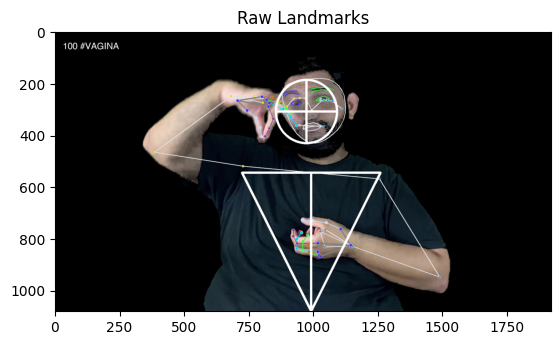

In [ ]:
i = 100
landmarks = np.load(os.path.join(
    path_to_root,
    "data",
    "interim",
    "RawPoseLandmarks",
    'versionA', metadata_row["filename"].split(".")[0] + ".npy"
    ), allow_pickle=True)
frame = viz.get_frame(i, os.path.join(path_to_root, 'data/raw/combined/videos', metadata_row.filename))
plot = mph.draw_landmarks_on_frame(frame, landmarks[i], )
viz.plot_key_landmarks(viz.landmarks_to_key_landmarks(landmarks[i]), plot, (255, 255, 255), triangle=True, line_width=7)

plt.imshow(plot)
plt.title('Raw Landmarks')
# plt.axhline(int(0.25*frame.shape[0]))
# plt.axhline(int((0.25-(0.23/2))*frame.shape[0]))
# plt.axhline(int((0.25+(0.23/2))*frame.shape[0]))
plt.show()


### Plot Key Points

In [49]:
analysis_info[[
    'metadata_data_source',
    'metadata_filename',
    'pose_analysis_horizontal_offsets_face_median',
    'pose_analysis_vertical_offsets_face_median',
    'pose_analysis_landmark_measurements_face_width_median',
    'pose_analysis_landmark_measurements_face_height_median',
    'pose_analysis_horizontal_offsets_shoulders_median',
    'pose_analysis_vertical_offsets_shoulders_median',
    'pose_analysis_landmark_measurements_shoulder_width_median',
]].sort_values(by='pose_analysis_vertical_offsets_shoulders_median')

,metadata_data_source,metadata_filename,pose_analysis_horizontal_offsets_face_median,pose_analysis_vertical_offsets_face_median,pose_analysis_landmark_measurements_face_width_median,pose_analysis_landmark_measurements_face_height_median,pose_analysis_horizontal_offsets_shoulders_median,pose_analysis_vertical_offsets_shoulders_median,pose_analysis_landmark_measurements_shoulder_width_median
0,uf,casa_uf_3.mp4,0.502358,0.220780,0.072527,0.156883,0.504407,0.390218,0.152219
0,vl,homem_vl_5.mp4,0.475248,0.127256,0.124190,0.238843,0.486667,0.396018,0.252168
0,vl,garganta_vl_4.mp4,0.500631,0.094502,0.123108,0.229071,0.527449,0.413689,0.255531
0,uf,sopa_uf_3.mp4,0.516334,0.275886,0.066533,0.151151,0.537999,0.413821,0.155933
0,vl,aniversário_vl_5.mp4,0.498556,0.215440,0.092056,0.189653,0.505911,0.420011,0.195151
...,...,...,...,...,...,...,...,...,...
0,vl,cebola_vl_5.mp4,0.484222,0.355169,0.129365,0.241275,0.473310,0.629739,0.251004
0,ne,garganta_ne_1.mp4,0.492699,0.265280,0.168523,0.273937,0.487077,0.632448,0.373562
0,ne,filho_ne_1.mp4,0.457302,0.286179,0.177789,0.304539,0.502913,0.636133,0.400845
0,ne,família_ne_1.mp4,0.490789,0.297791,0.179337,0.303256,0.494342,0.637091,0.389504


In [22]:
analysis_info_by_data_source = analysis_info[[
    'metadata_data_source',
    'pose_analysis_horizontal_offsets_face_median',
    'pose_analysis_vertical_offsets_face_median',
    'pose_analysis_landmark_measurements_face_width_median',
    'pose_analysis_landmark_measurements_face_height_median',
    'pose_analysis_horizontal_offsets_shoulders_median',
    'pose_analysis_vertical_offsets_shoulders_median',
    'pose_analysis_landmark_measurements_shoulder_width_median',
]].groupby('metadata_data_source').mean()
analysis_info_by_data_source

,pose_analysis_horizontal_offsets_face_median,pose_analysis_vertical_offsets_face_median,pose_analysis_landmark_measurements_face_width_median,pose_analysis_landmark_measurements_face_height_median,pose_analysis_horizontal_offsets_shoulders_median,pose_analysis_vertical_offsets_shoulders_median,pose_analysis_landmark_measurements_shoulder_width_median
metadata_data_source,,,,,,,
ne,0.486597,0.280021,0.152814,0.261346,0.504217,0.569399,0.336345
sb,0.505699,0.313221,0.087801,0.190641,0.515357,0.511277,0.198208
uf,0.512711,0.324346,0.083130,0.178148,0.511893,0.527957,0.189936
vl,0.493640,0.245085,0.117733,0.246735,0.499947,0.506230,0.247616


In [20]:
color_dict = {
    'ne': (0, 125, 255), # blue
    'vl': (0, 255, 0), # green
    'sb': (255, 0, 0), # red
    'uf': (255, 255, 0), # yellow
}

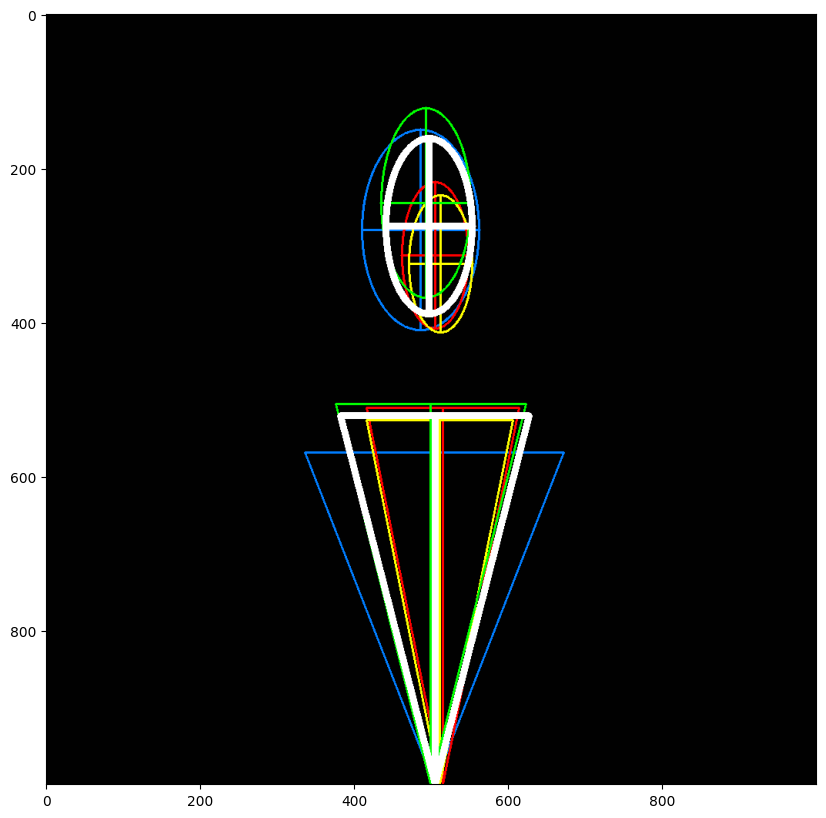

In [23]:
mean_ref_points = {
'face_horizontal_offset': analysis_info['pose_analysis_horizontal_offsets_face_median'].mean(),
'face_vertical_offset': analysis_info['pose_analysis_vertical_offsets_face_median'].mean(),
'face_width': analysis_info['pose_analysis_landmark_measurements_face_width_median'].mean(),
'face_height': analysis_info['pose_analysis_landmark_measurements_face_height_median'].mean(),
'shoulders_horizontal_offset': analysis_info['pose_analysis_horizontal_offsets_shoulders_median'].mean(),
'shoulders_vertical_offset': analysis_info['pose_analysis_vertical_offsets_shoulders_median'].mean(),
'shoulders_width': analysis_info['pose_analysis_landmark_measurements_shoulder_width_median'].mean(),
}
ref_points_by_data_source = {}
for data_source in analysis_info_by_data_source.index:
    ref_points_by_data_source[data_source] = {
        'face_horizontal_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_horizontal_offsets_face_median'].mean(),
        'face_vertical_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_vertical_offsets_face_median'].mean(),
        'face_width': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_face_width_median'].mean(),
        'face_height': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_face_height_median'].mean(),
        'shoulders_horizontal_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_horizontal_offsets_shoulders_median'].mean(),
        'shoulders_vertical_offset': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_vertical_offsets_shoulders_median'].mean(),
        'shoulders_width': analysis_info[
            analysis_info['metadata_data_source'] == data_source
        ]['pose_analysis_landmark_measurements_shoulder_width_median'].mean(),
    }

canvas_dims = 1000
canvas_ref = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
for data_source in ref_points_by_data_source.keys():
    canvas_ref = viz.plot_key_landmarks(
        ref_points_by_data_source[data_source], 
        canvas_ref, 
        color_dict[data_source], 
        triangle=True
    )
canvas_ref = viz.plot_key_landmarks(mean_ref_points, canvas_ref, (255, 255, 255), triangle=True, line_width=7)
plt.figure(figsize=(10, 10))
plt.imshow(canvas_ref)

In [41]:
canvas_dims = 1000
canvas_ne = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_vl = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_sb = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_uf = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)

for i, row in analysis_info.iterrows():
    data_source = row['metadata_data_source']
    color = color_dict[data_source]
    key_points = {
    'face_horizontal_offset': row['pose_analysis_horizontal_offsets_face_median'],
    'face_vertical_offset': row['pose_analysis_vertical_offsets_face_median'],
    'face_width': row['pose_analysis_landmark_measurements_face_width_median'],
    'face_height': row['pose_analysis_landmark_measurements_face_height_median'],
    'shoulders_horizontal_offset': row['pose_analysis_horizontal_offsets_shoulders_median'],
    'shoulders_vertical_offset': row['pose_analysis_vertical_offsets_shoulders_median'],
    'shoulders_width': row['pose_analysis_landmark_measurements_shoulder_width_median'],
    }
    if data_source == 'ne':
        canvas_ne = viz.plot_key_landmarks(key_points, canvas_ne, color, triangle=True)
    if data_source == 'vl':
        canvas_vl = viz.plot_key_landmarks(key_points, canvas_vl, color, triangle=True)
    if data_source == 'sb':
        canvas_sb = viz.plot_key_landmarks(key_points, canvas_sb, color, triangle=True)
    if data_source == 'uf':
        canvas_uf = viz.plot_key_landmarks(key_points, canvas_uf, color, triangle=True)
for canvas_datasource in [canvas_ne, canvas_vl, canvas_sb, canvas_uf]:
    viz.plot_key_landmarks(ref_points_by_data_source[data_source], canvas_datasource, (125, 125, 125), triangle=True, line_width=5)
    viz.plot_key_landmarks(mean_ref_points, canvas_datasource, (200, 200, 200), triangle=True, line_width=5)
canvas_top = np.hstack((canvas_ne, canvas_vl))
canvas_bottom = np.hstack((canvas_sb, canvas_uf))
canvas = np.vstack((canvas_top, canvas_bottom))
canvas = cv2.line(canvas, (0, canvas_dims), (canvas.shape[1], canvas_dims), (255, 255, 255), 5)
canvas = cv2.line(canvas, (canvas_dims, 0), (canvas_dims, canvas.shape[0]), (255, 255, 255), 5)

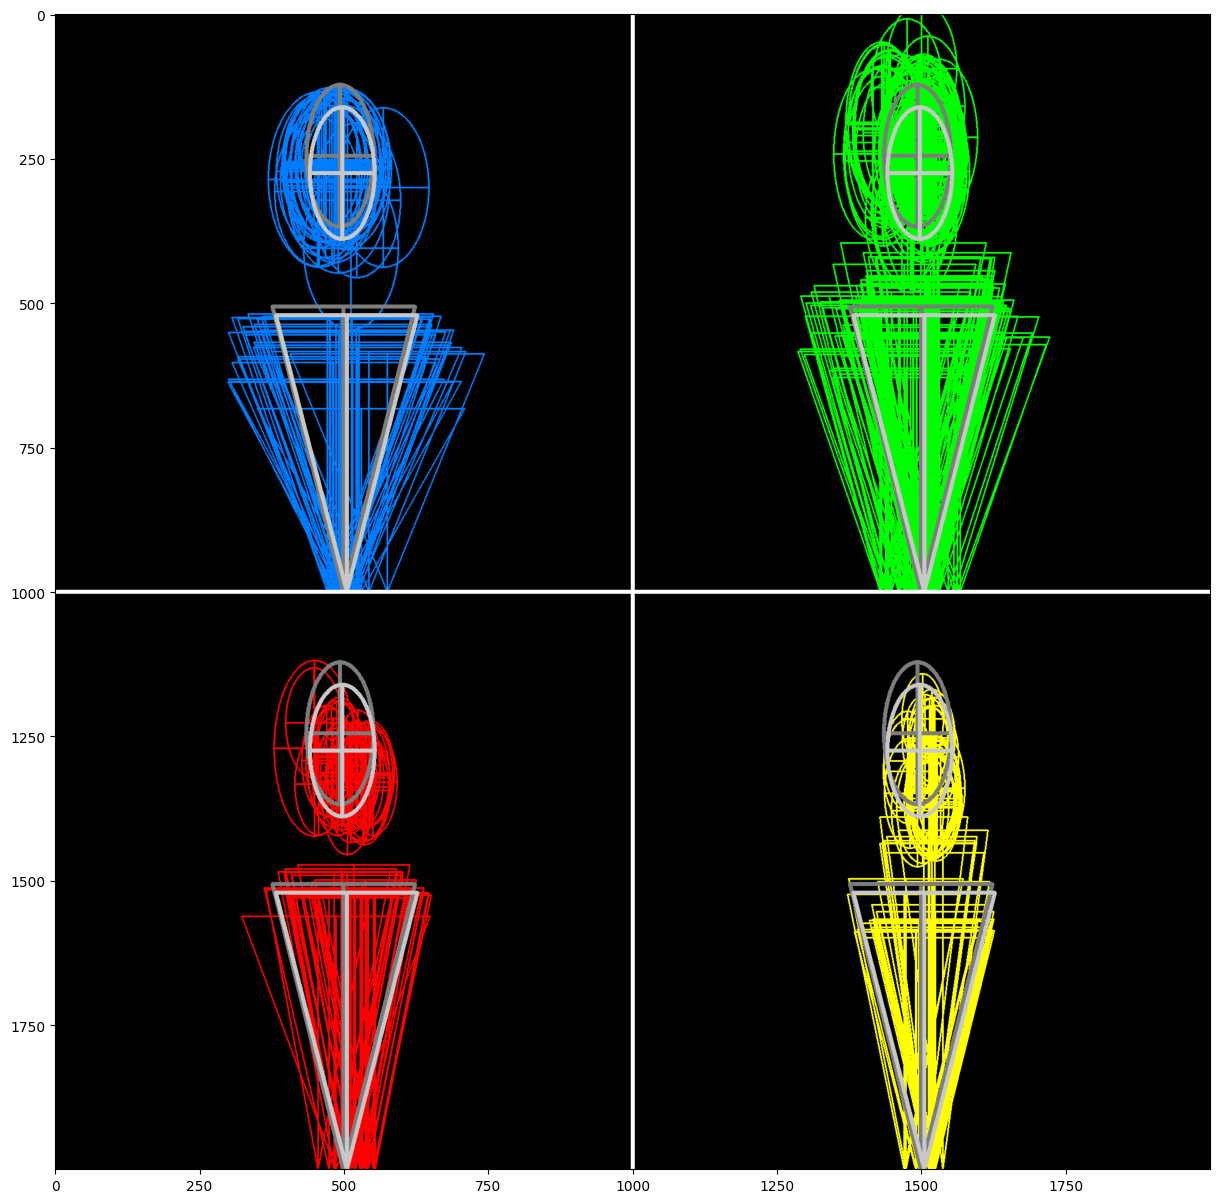

In [42]:
# figsie
plt.figure(figsize=(15, 15))
plt.imshow(canvas)

In [ ]:
reference_face = 0.25
reference_shoulders = 0.5
reference_face_width = 0.15
reference_shoulder_width = 0.3
reference_face_height = 0.2
reference_shoulder_height = 0.3

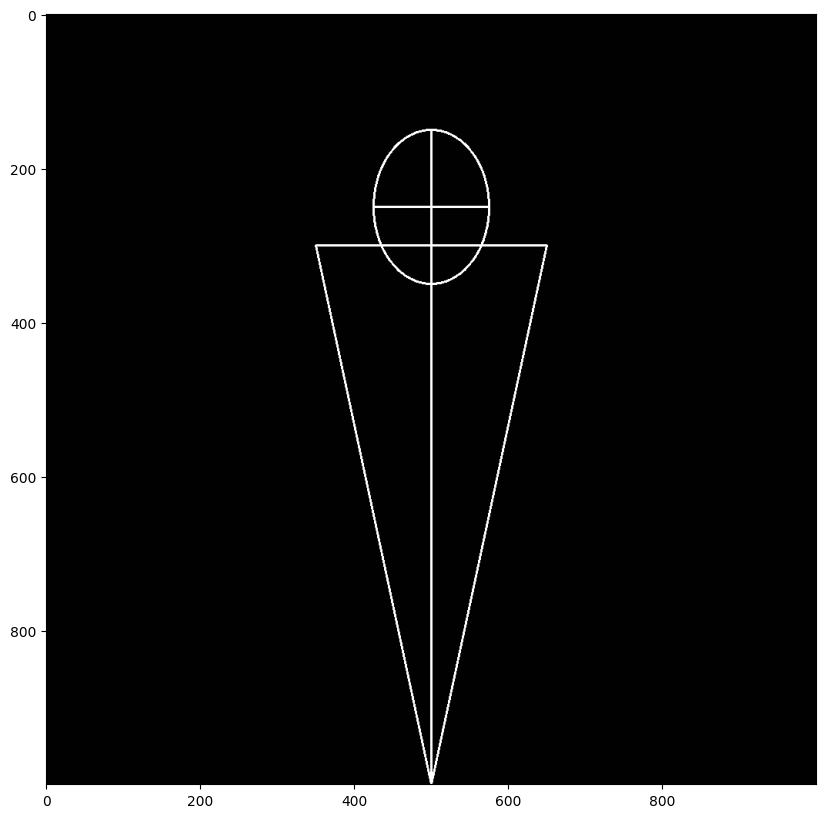

In [65]:
ref_points = {
'face_horizontal_offset': 0.5,
'face_vertical_offset': 0.25,
'face_width': 0.15,
'face_height': 0.2,
'shoulders_horizontal_offset': 0.5,
'shoulders_vertical_offset': 0.3,
'shoulders_width': 0.3,
}
canvas_dims = 1000
canvas_ref = np.ones((canvas_dims, canvas_dims, 3), dtype=np.uint8)
canvas_ref = viz.plot_key_landmarks(ref_points, canvas_ref, (255, 255, 255), triangle=True)
plt.figure(figsize=(10, 10))
plt.imshow(canvas_ref)

#### Start Frame / End Frame

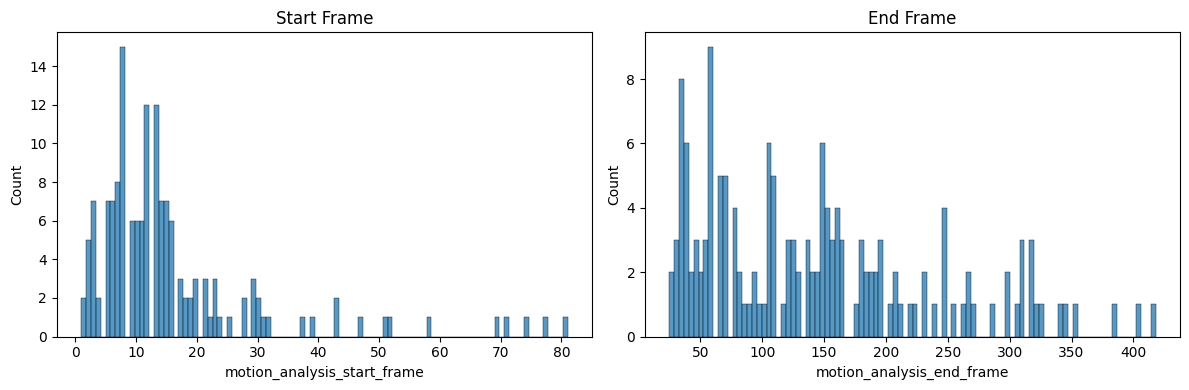

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(analysis_info.motion_analysis_start_frame, bins=100, ax=ax1)
ax1.set_title('Start Frame')
sns.histplot(analysis_info.motion_analysis_end_frame, bins=100, ax=ax2) 
ax2.set_title('End Frame')
plt.tight_layout()

<Axes: xlabel='motion_analysis_start_frame', ylabel='motion_analysis_end_frame'>

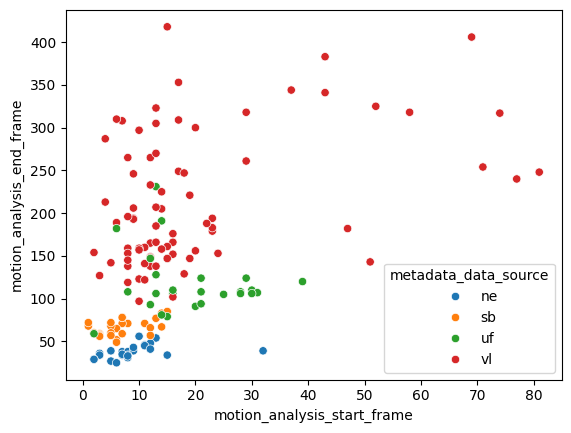

In [29]:
sns.scatterplot(x = 'motion_analysis_start_frame', y = 'motion_analysis_end_frame', data = analysis_info, hue = 'metadata_data_source')

#### Horizontal Offset

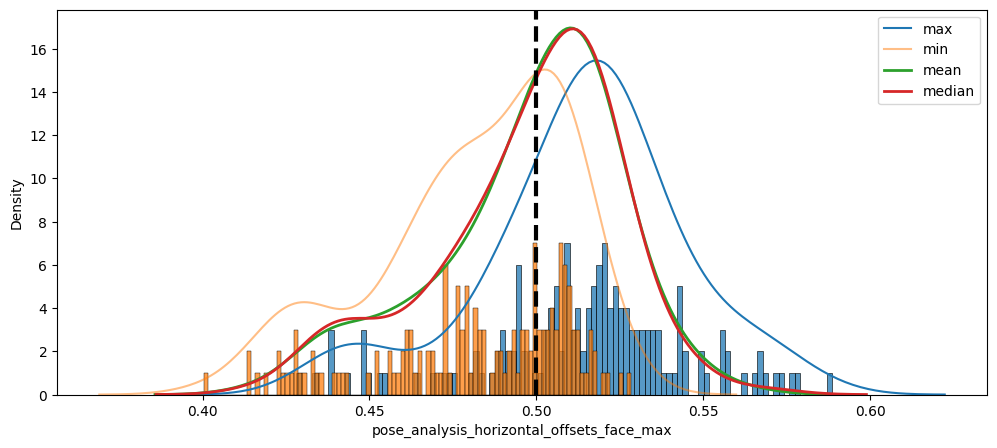

In [30]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_max)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_min, alpha = 0.5)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_face_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_face_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
plt.axvline(0.5, color = 'k', linewidth = 3, linestyle = '--')

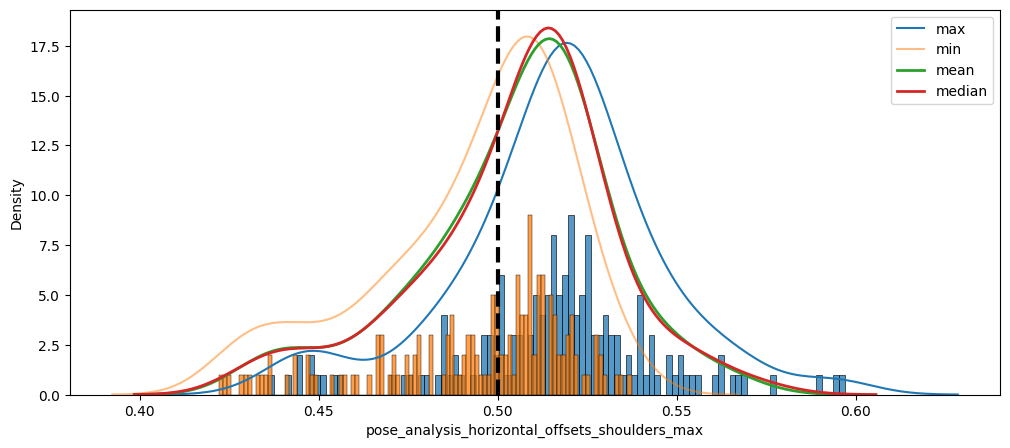

In [31]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_max)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_min, alpha = 0.5)
sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_horizontal_offsets_shoulders_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
plt.axvline(0.5, color = 'k', linewidth = 3, linestyle = '--')

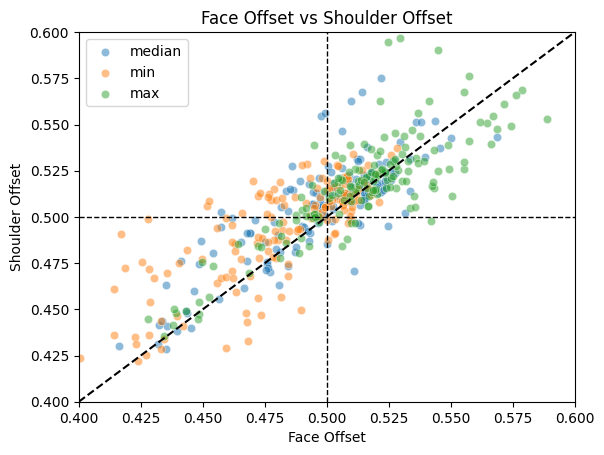

In [32]:
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_median, y = analysis_info.pose_analysis_horizontal_offsets_shoulders_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_min, y = analysis_info.pose_analysis_horizontal_offsets_shoulders_min, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_max, y = analysis_info.pose_analysis_horizontal_offsets_shoulders_max, alpha = 0.5)
plt.xlim(0.4, 0.6)
plt.ylim(0.4, 0.6)
plt.plot([0.4, 0.6], [0.4, 0.6], 'k--')
plt.xlabel('Face Offset')
plt.ylabel('Shoulder Offset')
plt.title('Face Offset vs Shoulder Offset')
plt.legend(['median', 'min', 'max'])
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')
plt.axhline(0.5, color = 'k', linewidth = 1, linestyle = '--')

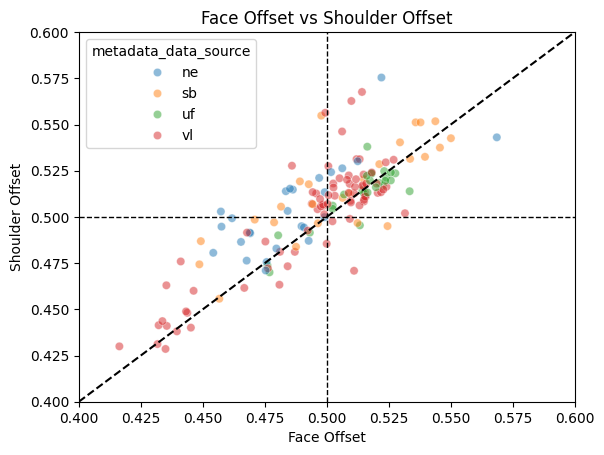

In [33]:
sns.scatterplot(x = 'pose_analysis_horizontal_offsets_face_median', y = 'pose_analysis_horizontal_offsets_shoulders_median', data = analysis_info, hue = 'metadata_data_source', alpha = 0.5)
plt.xlim(0.4, 0.6)
plt.ylim(0.4, 0.6)
plt.plot([0.4, 0.6], [0.4, 0.6], 'k--')
plt.xlabel('Face Offset')
plt.ylabel('Shoulder Offset')
plt.title('Face Offset vs Shoulder Offset')
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')
plt.axhline(0.5, color = 'k', linewidth = 1, linestyle = '--')

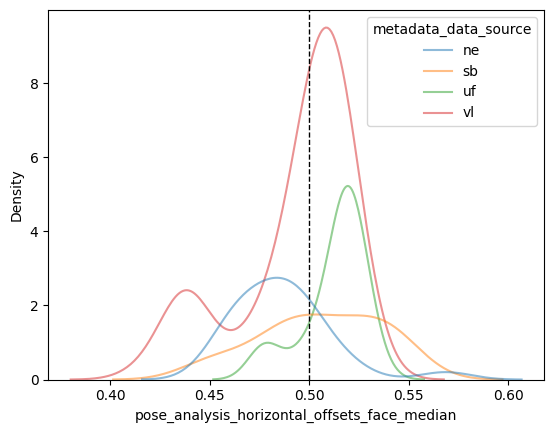

In [34]:
sns.kdeplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_face_median', hue = 'metadata_data_source', alpha = 0.5)
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')

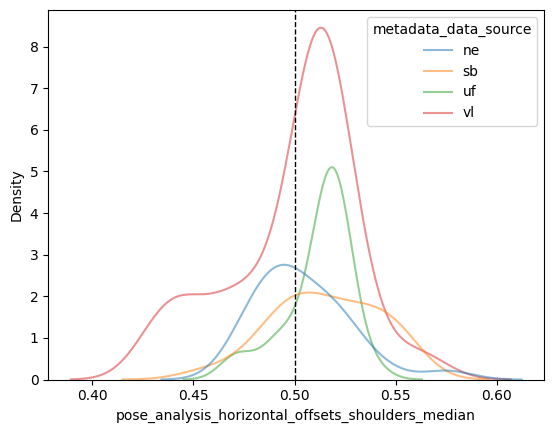

In [38]:
sns.kdeplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_shoulders_median', hue = 'metadata_data_source', alpha = 0.5)
plt.axvline(0.5, color = 'k', linewidth = 1, linestyle = '--')

In [40]:
analysis_info

,metadata_filename,metadata_fps,metadata_width,metadata_height,metadata_duration_sec,metadata_frame_count,metadata_data_source,metadata_label,metadata_motion_detection_version,metadata_pose_detection_version,...,pose_analysis_landmark_measurements_face_height_max,pose_analysis_landmark_measurements_top_head_to_shoulders_mean,pose_analysis_landmark_measurements_top_head_to_shoulders_median,pose_analysis_landmark_measurements_top_head_to_shoulders_max,pose_analysis_landmark_measurements_nose_to_shoulders_mean,pose_analysis_landmark_measurements_nose_to_shoulders_median,pose_analysis_landmark_measurements_nose_to_shoulders_max,pose_analysis_landmark_measurements_chin_to_shoulders_mean,pose_analysis_landmark_measurements_chin_to_shoulders_median,pose_analysis_landmark_measurements_chin_to_shoulders_max
0,ajudar_ne_1.mp4,12,240,176,3.666667,44,ne,ajudar,versionA,versionA,...,0.252707,0.389640,0.401485,0.424468,0.281364,0.295888,0.323883,0.143076,0.154860,0.180421
0,ajudar_sb_2.mp4,29,1280,720,2.635967,79,sb,ajudar,versionA,versionA,...,0.193873,0.273414,0.284555,0.320690,0.192239,0.202928,0.254801,0.089284,0.094580,0.139206
0,ajudar_uf_3.mp4,29,480,270,3.837167,115,uf,ajudar,versionA,versionA,...,0.202362,0.295165,0.305301,0.319739,0.197913,0.208376,0.227967,0.100119,0.112404,0.123043
0,ajudar_vl_4.mp4,29,1920,1080,4.704700,141,vl,ajudar,versionA,versionA,...,0.219142,0.314821,0.309862,0.358281,0.223784,0.217937,0.272717,0.101667,0.094653,0.141479
0,ajudar_vl_5.mp4,29,1920,1080,9.642967,289,vl,ajudar,versionA,versionA,...,0.258656,0.352089,0.350756,0.402961,0.247273,0.245240,0.302809,0.113110,0.110576,0.160659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,vagina_sb_2.mp4,29,1280,720,2.135467,64,sb,vagina,versionA,versionA,...,0.192092,0.269925,0.276957,0.300400,0.182761,0.190399,0.216230,0.083013,0.087943,0.110655
0,vagina_uf_3.mp4,29,480,270,3.670333,110,uf,vagina,versionA,versionA,...,0.183614,0.273870,0.286303,0.299445,0.187931,0.204516,0.220822,0.098965,0.111529,0.124660
0,vagina_vl_4.mp4,29,1920,1080,5.005000,150,vl,vagina,versionA,versionA,...,0.226608,0.315066,0.303168,0.358198,0.222575,0.209316,0.274654,0.101090,0.088101,0.146356
0,vagina_vl_5.mp4,29,1920,1080,7.173833,215,vl,vagina,versionA,versionA,...,0.302271,0.406252,0.402134,0.469440,0.277387,0.270796,0.344880,0.114410,0.107652,0.174818


#### X Scale Factor, Y Scale Factor

In [ ]:
analysis_info["pose_analysis"]["landmark_measurements"]

{'shoulder_width': {'mean': 0.19643654188049905,
  'median': 0.19426915924508475,
  'max': 0.2090008389332927},
 'hip_width': {'mean': 0.1257517734114194,
  'median': 0.12609480072645388,
  'max': 0.12865377607265074},
 'shoulder_to_hip': {'mean': 0.4793086848003729,
  'median': 0.47776501197933896,
  'max': 0.49827525282161705},
 'left_arm_length': {'mean': 0.24680996905222985,
  'median': 0.2298158988903358,
  'max': 0.3623422862255871},
 'right_arm_length': {'mean': 0.20022440832505897,
  'median': 0.18014849266203434,
  'max': 0.3336035031920863},
 'face_width': {'mean': 0.09077648767991894,
  'median': 0.08967295566002594,
  'max': 0.09869955922332911},
 'face_height': {'mean': 0.18541259318526834,
  'median': 0.1867652875494272,
  'max': 0.19387317661191944},
 'top_head_to_shoulders': {'mean': 0.2734140238807171,
  'median': 0.2845546454191208,
  'max': 0.3206898272037506},
 'nose_to_shoulders': {'mean': 0.19223914380314983,
  'median': 0.20292796194553375,
  'max': 0.25480055809

In [ ]:
# Measurements from the video
## Horizontal
shoulder_width = analysis_info["pose_analysis"]["landmark_measurements"]["shoulder_width"]["mean"]
face_width = analysis_info["pose_analysis"]["landmark_measurements"]["face_width"]["mean"]
## Vertical
face_height = analysis_info["pose_analysis"]["landmark_measurements"]["face_height"]["mean"]
chin_to_shoulders = analysis_info["pose_analysis"]["landmark_measurements"]["chin_to_shoulders"]["median"]

# Reference values to scale to
## Horizontal
reference_shoulder_width = 0.3
reference_face_width = 0.15
## Vertical
reference_face_height = 0.2
reference_chin_to_shoulders = 0.15

# Scale Factors
## Horizontal
shoulder_width_weight = 0.7
face_width_weight = 0.3
x_scale_factor = shoulder_width_weight * reference_shoulder_width / shoulder_width + face_width_weight * reference_face_width / face_width
## Vertical
face_height_weight = 0.7
chin_to_shoulders_weight = 0.3
y_scale_factor = face_height_weight * reference_face_height / face_height + chin_to_shoulders_weight * reference_chin_to_shoulders / chin_to_shoulders

x_scale_factor, y_scale_factor

(1.5647706098056886, 1.2308604879523808)

In [ ]:
# TODO: Plot the measured landmarks and the reference landmarks side by side

#### Vertical Offset

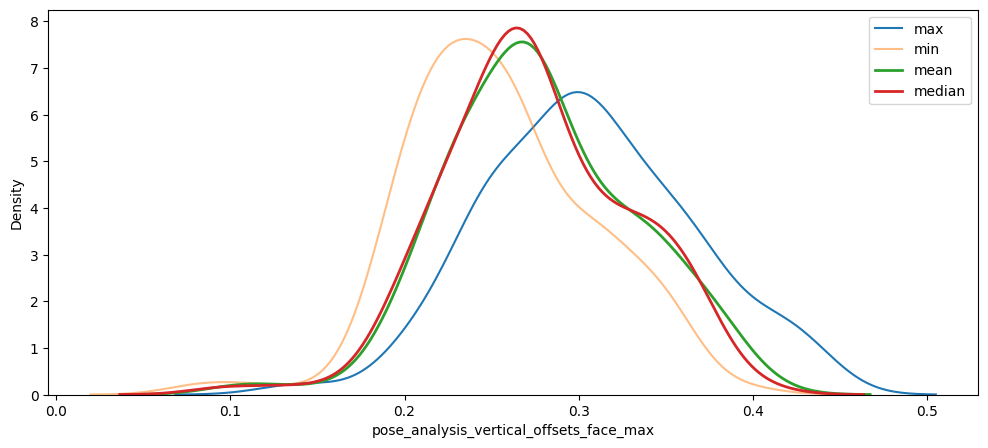

In [170]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_max)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_min, alpha = 0.5)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_face_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_face_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])
# plt.axvline(0.5, color = 'k', linewidth = 3, linestyle = '--')

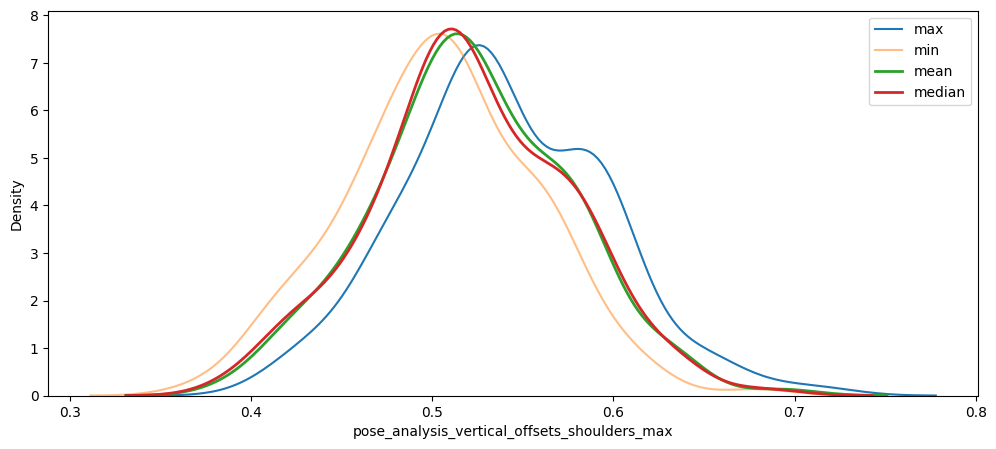

In [172]:
plt.figure(figsize=(12, 5))
sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_max)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_max, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_min, alpha = 0.5)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_min, bins=100)

sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_mean, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_mean, bins=100)


sns.kdeplot(analysis_info.pose_analysis_vertical_offsets_shoulders_median, linewidth = 2)
# sns.histplot(analysis_info.pose_analysis_vertical_offsets_shoulders_median, bins=100)
#
plt.legend(['max', 'min', 'mean', 'median'])

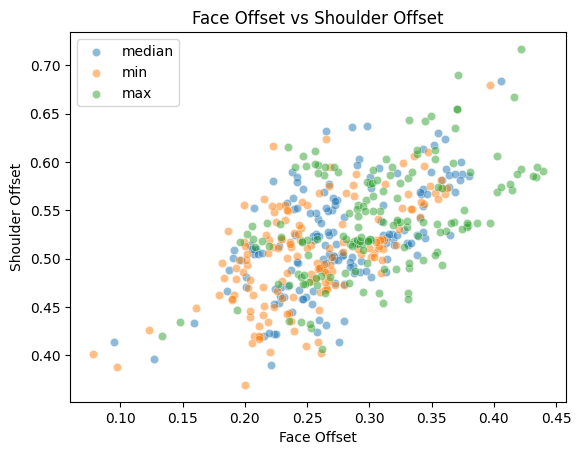

In [174]:
sns.scatterplot(x = analysis_info.pose_analysis_vertical_offsets_face_median, y = analysis_info.pose_analysis_vertical_offsets_shoulders_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_vertical_offsets_face_min, y = analysis_info.pose_analysis_vertical_offsets_shoulders_min, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_vertical_offsets_face_max, y = analysis_info.pose_analysis_vertical_offsets_shoulders_max, alpha = 0.5)

plt.xlabel('Face Offset')
plt.ylabel('Shoulder Offset')
plt.title('Face Offset vs Shoulder Offset')
plt.legend(['median', 'min', 'max'])

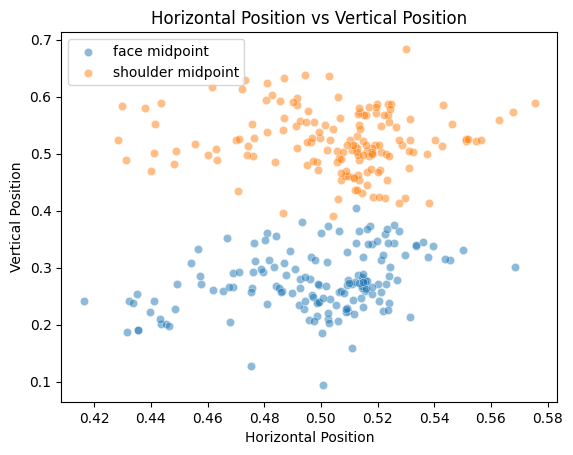

In [181]:
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_median, y = analysis_info.pose_analysis_vertical_offsets_face_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_shoulders_median, y = analysis_info.pose_analysis_vertical_offsets_shoulders_median, alpha = 0.5)

plt.xlabel('Horizontal Position')
plt.ylabel('Vertical Position')
plt.title('Horizontal Position vs Vertical Position')
plt.legend(['face midpoint', 'shoulder midpoint'])

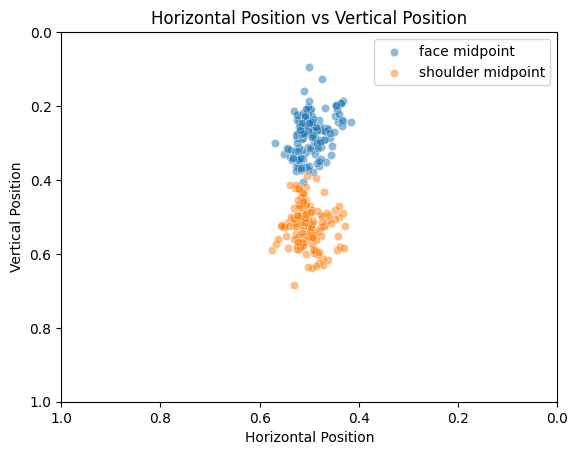

In [185]:
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_face_median, y = analysis_info.pose_analysis_vertical_offsets_face_median, alpha = 0.5)
sns.scatterplot(x = analysis_info.pose_analysis_horizontal_offsets_shoulders_median, y = analysis_info.pose_analysis_vertical_offsets_shoulders_median, alpha = 0.5)
plt.xlim(1, 0)
plt.ylim(1, 0)
plt.xlabel('Horizontal Position')
plt.ylabel('Vertical Position')
plt.title('Horizontal Position vs Vertical Position')
plt.legend(['face midpoint', 'shoulder midpoint'])

Text(0.5, 1.0, 'Horizontal Position vs Vertical Position for Face and Shoulder Midpoints')

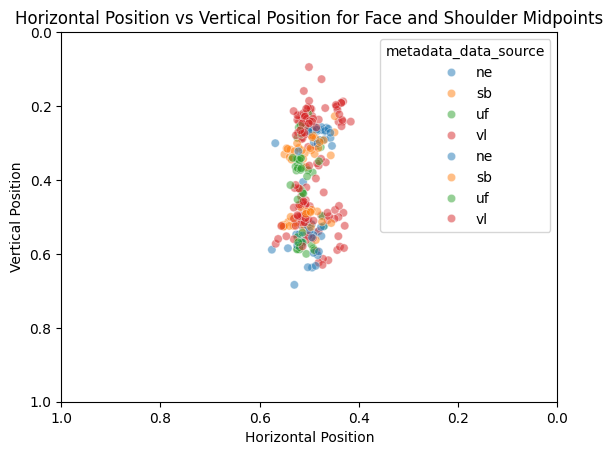

In [190]:
sns.scatterplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_face_median', y = 'pose_analysis_vertical_offsets_face_median', alpha = 0.5, hue = 'metadata_data_source')
sns.scatterplot(data = analysis_info, x = 'pose_analysis_horizontal_offsets_shoulders_median', y = 'pose_analysis_vertical_offsets_shoulders_median', alpha = 0.5, hue = 'metadata_data_source')
plt.xlim(1, 0)
plt.ylim(1, 0)
plt.xlabel('Horizontal Position')
plt.ylabel('Vertical Position')
plt.title('Horizontal Position vs Vertical Position for Face and Shoulder Midpoints')

#### Target Duration

<Axes: xlabel='motion_analysis_duration_sec', ylabel='Count'>

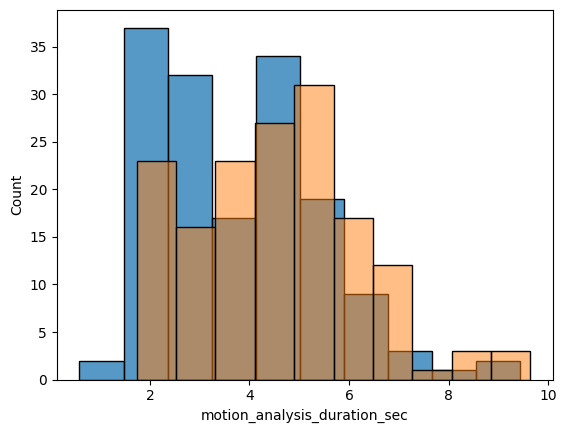

In [ ]:
sns.histplot(data=analysis_info, x = 'motion_analysis_duration_sec')
sns.histplot(data=analysis_info, x = 'metadata_duration_sec', alpha = 0.5)

<Axes: xlabel='metadata_duration_sec', ylabel='Density'>

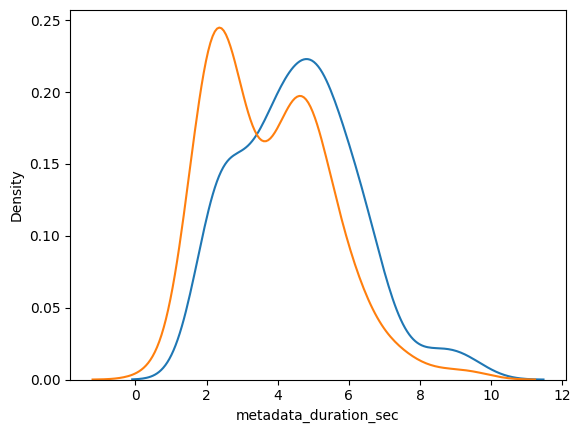

In [202]:
sns.kdeplot(data=analysis_info, x = 'metadata_duration_sec', )
sns.kdeplot(data=analysis_info, x = 'motion_analysis_duration_sec',)

<Axes: xlabel='metadata_duration_sec', ylabel='Density'>

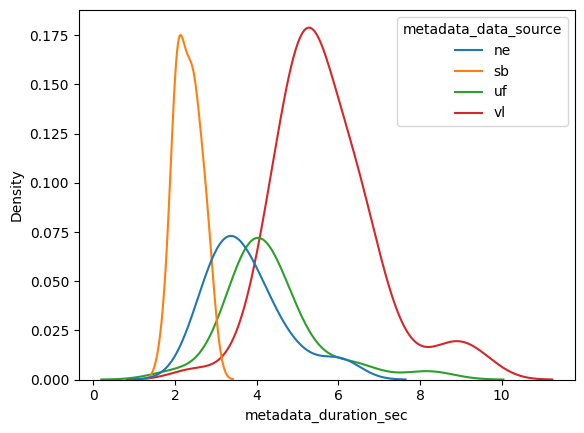

In [200]:
sns.kdeplot(data=analysis_info, x = 'metadata_duration_sec', hue = 'metadata_data_source')

<Axes: xlabel='motion_analysis_duration_sec', ylabel='Density'>

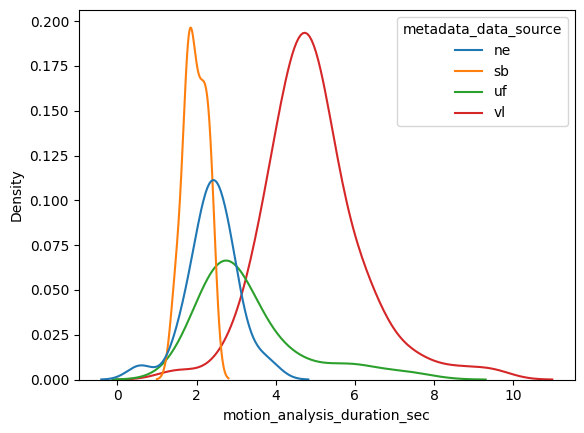

In [201]:
sns.kdeplot(data=analysis_info, x = 'motion_analysis_duration_sec', hue = 'metadata_data_source')

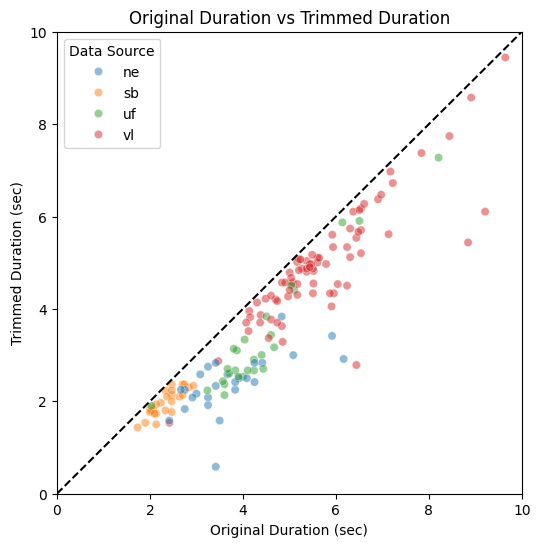

In [191]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x = 'metadata_duration_sec', y = 'motion_analysis_duration_sec', data = analysis_info, hue = 'metadata_data_source', alpha = 0.5)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.plot([0, 10], [0, 10], 'k--')
plt.xlabel('Original Duration (sec)')
plt.ylabel('Trimmed Duration (sec)')
plt.title('Original Duration vs Trimmed Duration')
plt.legend(title='Data Source')
plt.show()


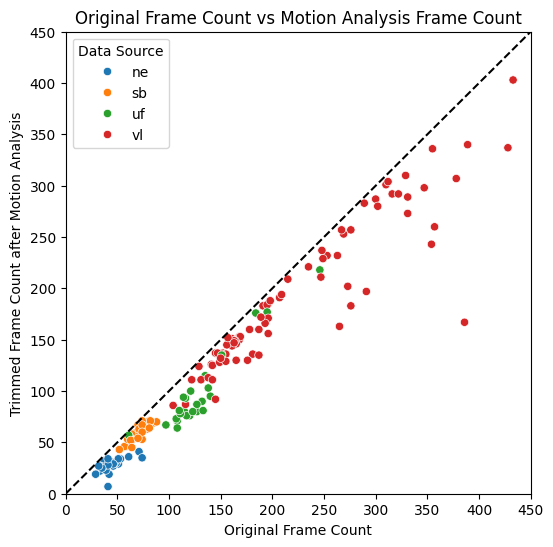

In [192]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x = 'metadata_frame_count', y = 'motion_analysis_duration_frames', data = analysis_info, hue = 'metadata_data_source')
plt.xlim(0, 450)
plt.ylim(0, 450)
plt.plot([0, 450], [0, 450], 'k--')
plt.xlabel('Original Frame Count')
plt.ylabel('Trimmed Frame Count after Motion Analysis')
plt.title('Original Frame Count vs Motion Analysis Frame Count')
plt.legend(title='Data Source')
plt.show()

## i = 1

In [14]:
with open(os.path.join(
    path_to_root, 
    "data", 
    "interim", 
    "Analysis", 
    "28032025", 
    "individual_json", 
    metadata_row["filename"].split(".")[0] + "_analysis_info.json"
    )) as f:
    analysis_info = json.load(f)

analysis_info.keys()

dict_keys(['metadata', 'params', 'motion_analysis', 'pose_analysis'])

In [16]:
video_path = os.path.join(
    path_to_root,
    "data",
    "raw",
    "combined",
    "videos",
    metadata_row["filename"]
)
frame = get_frame(20, video_path)

In [17]:
landmark_stages = {
    0: {
        "suffix": "",
        "description": "Raw Landmarks"
    },
    1: {
        "suffix": "_1_trimmed",
        "description": "Trimmed Landmarks"
    },
    2: {
        "suffix": "_2_h_aligned",
        "description": "Horizontal Aligned Landmarks"
    },
    3: {
        "suffix": "_3_scaled",
        "description": "Scaled Landmarks"
    },
    4: {
        "suffix": "_4_v_aligned",
        "description": "Vertical Aligned Landmarks"
    },
    5: {
        "suffix": "_5_padded",
        "description": "Padded Landmarks"
    },
    6: {
        "suffix": "_6_cropped",
        "description": "Cropped Landmarks"
    },
}

In [18]:
for stage in landmark_stages:
    landmarks_path = os.path.join(
        path_to_root,
        "data",
        "interim",
        "RawPoseLandmarks",
        'versionA', metadata_row["filename"].split(".")[0] + landmark_stages[stage]["suffix"] + ".npy")
    if os.path.exists(landmarks_path):
        landmarks = np.load(landmarks_path, allow_pickle=True)
        print(f"Landmarks loaded from {landmarks_path}")
        landmark_stages[stage]["landmarks"] = landmarks
    else:
        print(f"Landmarks not found at {landmarks_path}")
    

2025-03-31 21:25:08.732927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743423908.778983   48042 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743423908.796891   48042 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 21:25:08.915373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_1_trimmed.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_2_h_aligned.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_3_scaled.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_4_v_aligned.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLandmarks/versionA/ajudar_sb_2_5_padded.npy
Landmarks loaded from /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawPoseLan

### EDA